In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from dotenv import load_dotenv
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sqlalchemy

In [14]:
#load from .env file
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

load_dotenv(f'{parent_dir}/.env')

postgres_password = os.getenv('POSTGRES_PASSWORD')
postgres_port_no = os.getenv('POSTGRES_PORT_NO')
host = os.getenv('POSTGRES_HOST')
database = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')

## Tables

In [15]:
# Create database engine
engine = sqlalchemy.create_engine(f'postgresql://{user}:{postgres_password}@{host}:{postgres_port_no}/{database}')


In [16]:
postgres_port_no

'5433'

In [17]:
def create_df(table_name):
    try:
        connection = engine.connect() # Connect to the database
        query = f'''
        SELECT 
            *
        FROM
            {table_name} 
        '''
        # Read data from the database into a DataFrame
        df = pd.read_sql(query, con=connection)
        return df
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback()  # Rollback in case of error
    finally:
        connection.close()  # Close the connection

In [18]:
online_sales = create_df('online_sales')
online_sales

,user_id,transaction_id,date,product_id,Quantity,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct
0,17850,16679,2019-01-01,B09DL9978Y,1,6.50,Used,ELEC10,0.1
1,17850,16680,2019-01-01,B09DL9978Y,1,6.50,Used,ELEC10,0.1
2,17850,16681,2019-01-01,B07GXHC691,1,6.50,Used,OFF10,0.1
3,17850,16682,2019-01-01,B08NCKT9FG,5,6.50,Not Used,SALE10,0.1
4,17850,16682,2019-01-01,B08H21B6V7,1,6.50,Used,AIO10,0.1
...,...,...,...,...,...,...,...,...,...
53696,14410,48493,2019-12-31,B07XLML2YS,1,6.50,Clicked,ELEC30,0.3
53697,14410,48494,2019-12-31,B09WN3SRC7,1,6.50,Used,SALE30,0.3
53698,14410,48495,2019-12-31,B07VX71FZP,1,6.50,Used,ELEC30,0.3
53699,14600,48496,2019-12-31,B00Y4ORQ46,5,6.50,Clicked,ELEC30,0.3


In [19]:
# get products table

products = create_df('products')
products

,product_id,product_name,about_product,category,actual_price,discounted_price,discount_percentage
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,High Compatibility : Compatible With iPhone 12...,Computers&Accessories|Accessories&Peripherals|...,13.19,4.79,0.64
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,"Compatible with all Type C enabled devices, be...",Computers&Accessories|Accessories&Peripherals|...,4.19,2.39,0.43
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,【 Fast Charger& Data Sync】-With built-in safet...,Computers&Accessories|Accessories&Peripherals|...,22.79,2.39,0.90
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,The boAt Deuce USB 300 2 in 1 cable is compati...,Computers&Accessories|Accessories&Peripherals|...,8.39,3.95,0.53
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,[CHARGE & SYNC FUNCTION]- This cable comes wit...,Computers&Accessories|Accessories&Peripherals|...,4.79,1.85,0.61
...,...,...,...,...,...,...,...
1346,B00TI8E7BI,Philips HD9306/06 1.5-Litre Electric Kettle (M...,"Food grade stainless steel, Frequency: 50 Hz. ...",Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,32.34,32.34,0.00
1347,B07J9KXQCC,"Libra Room Heater for Home, Room Heaters Home ...","Libra room heater for home has cool, warm or h...","Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",27.59,11.39,0.59
1348,B0B3JSWG81,NGI Store 2 Pieces Pet Hair Removers for Your ...,"Versatile, Protects Your Clothes: MoveCatcher ...","Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...",11.99,2.39,0.80
1349,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,11.03,4.55,0.59


In [20]:
# get ratings table

ratings = create_df('ratings')
ratings

,product_id,average_rating,review_title,review_content,rating_count
0,B002PD61Y4,4.1,"good tool to use for,Brand is always good,Over...",good quality tool from d linkWiFi signal is go...,16262
1,B002SZEOLG,4.2,Works on linux for me. Get the model with ante...,I use this to connect an old PC to internet. I...,179692
2,B003B00484,4.3,"Works Good,Perfect replacement cell for trimme...","Works good,Bought it to replace my Phillips QT...",27201
3,B003L62T7W,4.3,"Handy Mouse,Good quality mouse,Good one.,Good,...","Liked this Product,https://m.media-amazon.com/...",31534
4,B004IO5BMQ,4.5,"Good silent mouse,Too small to hold!,Reviewing...",It's little small for big hands. But best avai...,54405
...,...,...,...,...,...
1346,B0BPCJM7TB,4.0,"Nice frother,Nice product I like this product,...",This is my first coffee frother and I just lov...,43
1347,B0BPJBTB3F,2.0,"Bad quality,Amazing product..",The heating capacity is zero .Moreover i have ...,2
1348,B0BQ3K23Y1,4.8,"Oratech Best Coffee Frother,Great,My review ab...","Overall, I love this Oratech Coffee frother an...",28
1349,B0BQRJ3C47,5.0,Awesome Product,Quick delivery.Awesome ProductPacking was good...,0


In [21]:
# get users table

users = create_df('users')
users

,user_id,age,gender
0,1,23,Female
1,2,23,Female
2,3,24,Prefer not to say
3,4,24,Female
4,5,22,Female
...,...,...,...
2065,14438,57,Female
2066,12956,60,Female
2067,15781,55,Male
2068,14410,19,Female


## Part 1: Analyze historical sales data

### EDA

In [22]:
online_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53701 entries, 0 to 53700
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           53701 non-null  int64         
 1   transaction_id    53701 non-null  int64         
 2   date              53701 non-null  datetime64[ns]
 3   product_id        53701 non-null  object        
 4   Quantity          53701 non-null  int64         
 5   Delivery_Charges  53701 non-null  float64       
 6   Coupon_Status     53701 non-null  object        
 7   Coupon_Code       53701 non-null  object        
 8   Discount_pct      53701 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 3.7+ MB


In [23]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1351 non-null   object 
 1   product_name         1351 non-null   object 
 2   about_product        1351 non-null   object 
 3   category             1351 non-null   object 
 4   actual_price         1351 non-null   float64
 5   discounted_price     1351 non-null   float64
 6   discount_percentage  1351 non-null   float64
dtypes: float64(3), object(4)
memory usage: 74.0+ KB


In [24]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      1351 non-null   object 
 1   average_rating  1351 non-null   float64
 2   review_title    1351 non-null   object 
 3   review_content  1351 non-null   object 
 4   rating_count    1351 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 52.9+ KB


In [25]:
# Join online_sales, users, products and ratings tables
historical_sales = online_sales.copy()
historical_sales = pd.merge(historical_sales, users, on='user_id', how='inner')
historical_sales = pd.merge(historical_sales, products, on='product_id', how='inner')
historical_sales = pd.merge(historical_sales, ratings, on='product_id', how='inner')
historical_sales.head()

,user_id,transaction_id,date,product_id,Quantity,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct,age,...,product_name,about_product,category,actual_price,discounted_price,discount_percentage,average_rating,review_title,review_content,rating_count
0,17850,16679,2019-01-01,B09DL9978Y,1,6.5,Used,ELEC10,0.1,33,...,Hindware Atlantic Compacto 3 Litre Instant wat...,Stainless Steel Tank|Copper Heating element|IS...,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...",55.08,28.79,0.48,4.1,"Good heater, and delivery and installation was...",The instant heater was well made. And works we...,444
1,17850,16680,2019-01-01,B09DL9978Y,1,6.5,Used,ELEC10,0.1,33,...,Hindware Atlantic Compacto 3 Litre Instant wat...,Stainless Steel Tank|Copper Heating element|IS...,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...",55.08,28.79,0.48,4.1,"Good heater, and delivery and installation was...",The instant heater was well made. And works we...,444
2,17850,16681,2019-01-01,B07GXHC691,1,6.5,Used,OFF10,0.1,33,...,STRIFF PS2_01 Multi Angle Mobile/Tablet Tablet...,"[PORTABLE SIZE]- 98mm*96mm*19mm, STRIFF desk p...",Electronics|Mobiles&Accessories|MobileAccessor...,5.99,1.19,0.80,4.3,"Good Stand For Mobiles !,Nice produt,Useful,Af...",This is good mobile stand. Sturdy with mobiles...,42641
3,17850,16682,2019-01-01,B08NCKT9FG,5,6.5,Not Used,SALE10,0.1,33,...,Boat A 350 Type C Cable 1.5m(Jet Black),"2 years warranty from the date of purchase, yo...",Computers&Accessories|Accessories&Peripherals|...,9.58,3.59,0.63,4.4,"Good Stuff... Recommended!!!,Need better quali...","Good Stuff... Recommended!!!,Need better quali...",28791
4,17850,16682,2019-01-01,B08H21B6V7,1,6.5,Used,AIO10,0.1,33,...,Nokia 150 (2020) (Cyan),MicroSD card slot expandable up to 32. Network...,Electronics|Mobiles&Accessories|Smartphones&Ba...,35.99,31.19,0.13,3.9,"Ok phone,Good Basic Phone,Nice one,Hghjk,Good ...",Audio contains lots of distortion when using s...,14266


In [26]:
historical_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53701 entries, 0 to 53700
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53701 non-null  int64         
 1   transaction_id       53701 non-null  int64         
 2   date                 53701 non-null  datetime64[ns]
 3   product_id           53701 non-null  object        
 4   Quantity             53701 non-null  int64         
 5   Delivery_Charges     53701 non-null  float64       
 6   Coupon_Status        53701 non-null  object        
 7   Coupon_Code          53701 non-null  object        
 8   Discount_pct         53701 non-null  float64       
 9   age                  53701 non-null  int64         
 10  gender               53701 non-null  object        
 11  product_name         53701 non-null  object        
 12  about_product        53701 non-null  object        
 13  category             53701 non-

In [27]:
# check duplicated rows
historical_sales[historical_sales.duplicated(subset=['user_id', 'transaction_id', 'product_id', 'Quantity'])].shape

(3987, 21)

In [28]:
# drop duplicated rows
historical_sales = historical_sales.drop_duplicates(subset=['user_id', 'transaction_id', 'product_id', 'Quantity'], keep='first')

In [29]:
historical_sales.shape

(49714, 21)

In [30]:
historical_sales['Coupon_Status'].value_counts()

Coupon_Status
Clicked     25276
Used        16803
Not Used     7635
Name: count, dtype: int64

Create a total_price column where total_price = discounted_price x quantity if the Coupon_Status was used, and total_price = actual_price x quantity otherwise. In this case, a Clicked Coupon_Status means that a customer tried to use the coupon but it was not applicable to the product.

In [31]:
historical_sales['total_price'] = np.where(
    historical_sales['Coupon_Status'] == 'Used',
    historical_sales['Quantity'] * historical_sales['discounted_price'],
    historical_sales['Quantity'] * historical_sales['actual_price']
)
historical_sales.head()

,user_id,transaction_id,date,product_id,Quantity,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct,age,...,about_product,category,actual_price,discounted_price,discount_percentage,average_rating,review_title,review_content,rating_count,total_price
0,17850,16679,2019-01-01,B09DL9978Y,1,6.5,Used,ELEC10,0.1,33,...,Stainless Steel Tank|Copper Heating element|IS...,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...",55.08,28.79,0.48,4.1,"Good heater, and delivery and installation was...",The instant heater was well made. And works we...,444,28.79
1,17850,16680,2019-01-01,B09DL9978Y,1,6.5,Used,ELEC10,0.1,33,...,Stainless Steel Tank|Copper Heating element|IS...,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...",55.08,28.79,0.48,4.1,"Good heater, and delivery and installation was...",The instant heater was well made. And works we...,444,28.79
2,17850,16681,2019-01-01,B07GXHC691,1,6.5,Used,OFF10,0.1,33,...,"[PORTABLE SIZE]- 98mm*96mm*19mm, STRIFF desk p...",Electronics|Mobiles&Accessories|MobileAccessor...,5.99,1.19,0.80,4.3,"Good Stand For Mobiles !,Nice produt,Useful,Af...",This is good mobile stand. Sturdy with mobiles...,42641,1.19
3,17850,16682,2019-01-01,B08NCKT9FG,5,6.5,Not Used,SALE10,0.1,33,...,"2 years warranty from the date of purchase, yo...",Computers&Accessories|Accessories&Peripherals|...,9.58,3.59,0.63,4.4,"Good Stuff... Recommended!!!,Need better quali...","Good Stuff... Recommended!!!,Need better quali...",28791,47.90
4,17850,16682,2019-01-01,B08H21B6V7,1,6.5,Used,AIO10,0.1,33,...,MicroSD card slot expandable up to 32. Network...,Electronics|Mobiles&Accessories|Smartphones&Ba...,35.99,31.19,0.13,3.9,"Ok phone,Good Basic Phone,Nice one,Hghjk,Good ...",Audio contains lots of distortion when using s...,14266,31.19


In [32]:
# rename category to subcategory
# create new column "category" which serves as the overall category for each product
historical_sales.rename(columns={'category':'subcategory'}, inplace=True)
historical_sales['category'] = historical_sales['subcategory'].apply(lambda x: str.split(x, sep='|')[0])
historical_sales['category'].value_counts()

category
Electronics              24319
Home&Kitchen             13388
Computers&Accessories    10034
OfficeProducts            1946
MusicalInstruments          27
Name: count, dtype: int64

#### Ratings analysis

In [33]:
historical_sales_by_product = historical_sales.drop_duplicates(subset='product_id')
historical_sales_by_product.shape

(133, 23)

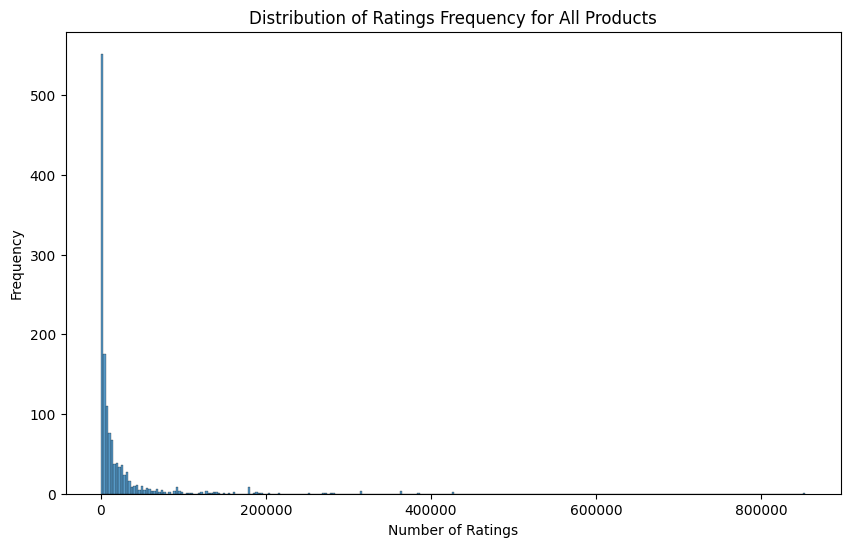

In [34]:
plt.figure(figsize=(10,6))
sns.histplot(data=ratings, x="rating_count")
plt.title("Distribution of Ratings Frequency for All Products")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

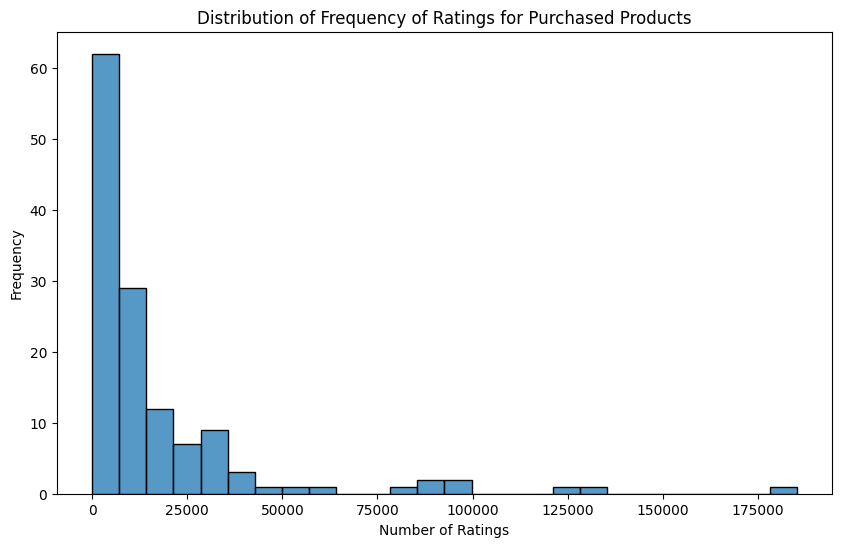

In [35]:
plt.figure(figsize=(10,6))
sns.histplot(data=historical_sales_by_product, x="rating_count")
plt.title("Distribution of Frequency of Ratings for Purchased Products")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

In [36]:
print(f"Number of products with less than 1000 ratings: {historical_sales_by_product[historical_sales_by_product['rating_count']<1000].shape[0]}")

Number of products with less than 1000 ratings: 30


Even though the ratings frequency is heavily right skewed with some outliers, majority of the products still have a review of at least a thousand, which can give insightful feedback to potential buyers.

#### Coupon and Discount percentage analysis

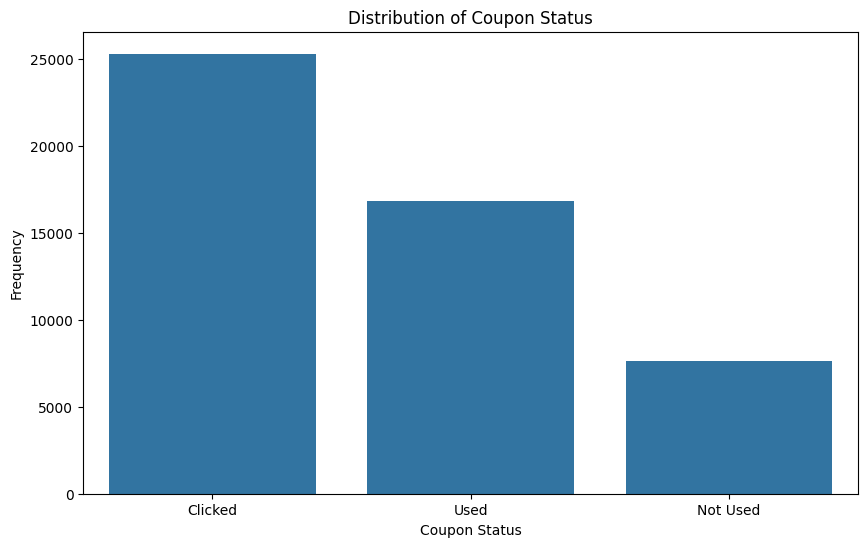

In [37]:
historical_sales_coupon = historical_sales['Coupon_Status'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=historical_sales_coupon.index, y=historical_sales_coupon.values)
plt.title("Distribution of Coupon Status")
plt.xlabel("Coupon Status")
plt.ylabel("Frequency")
plt.show()

Majority of the coupons were clicked but not applied. This could indicate uncertainty with regards to whether a coupon is applicable to the product or not and could be an area of improvement for the platform. 

Text(0.5, 0, 'Discount Percentage')

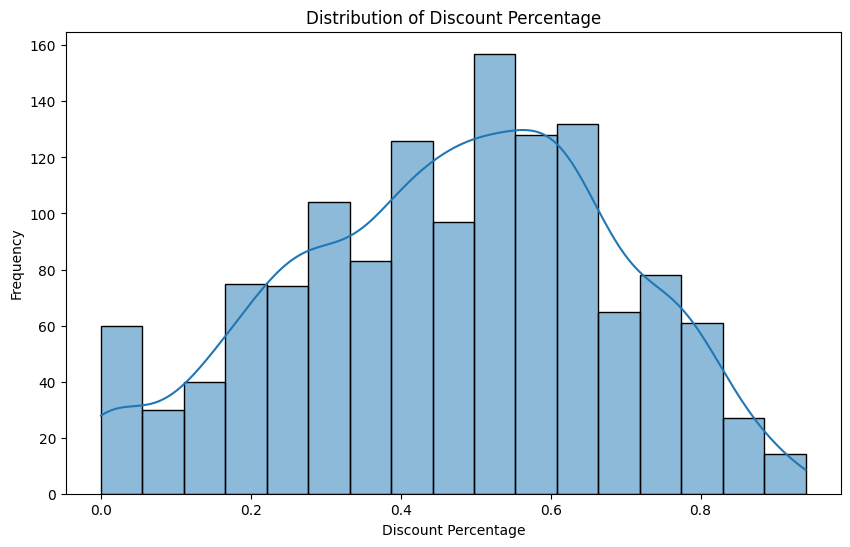

In [38]:
plt.figure(figsize=(10,6))
sns.histplot(products, x='discount_percentage', kde=True)
plt.title("Distribution of Discount Percentage")
plt.ylabel("Frequency")
plt.xlabel("Discount Percentage")

The discount percentage generally follows a normal distribution with the exception of a slight right skew. However, this is to be expected as not all products will have a discount applied to them.

Text(0.5, 1.0, 'Scatter plot of Actual Price against Discount Percentage')

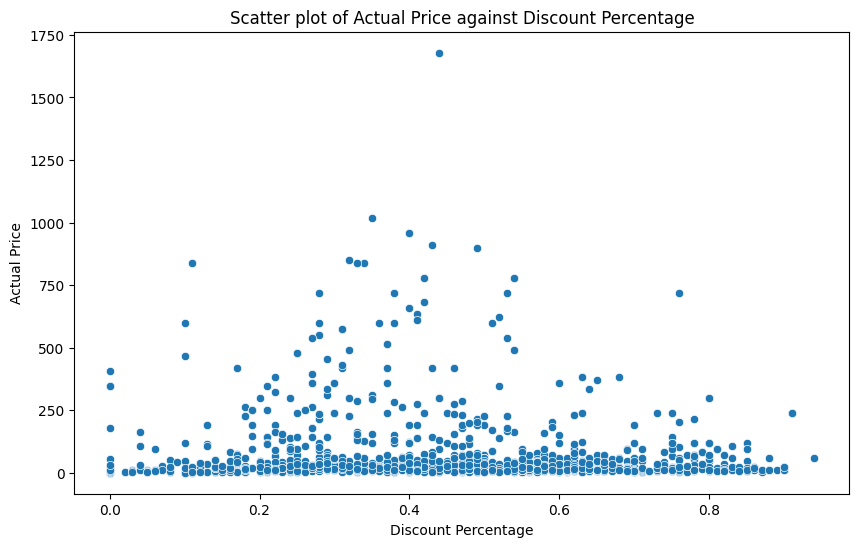

In [39]:
plt.figure(figsize=(10,6))
sns.scatterplot(products, x='discount_percentage', y='actual_price')
plt.ylabel('Actual Price')
plt.xlabel('Discount Percentage')
plt.title('Scatter plot of Actual Price against Discount Percentage')

There is no strong correlation between actual price and discount percedntage, especially when the actual price is below USD 125.

#### Historical sales analysis

In [40]:
# Aggregate by day
daily_sales = historical_sales.groupby(historical_sales['date'].dt.date).agg(total_sales=('total_price', 'sum')).reset_index()

# Aggregate by month
monthly_sales = historical_sales.groupby(historical_sales['date'].dt.to_period('M')).agg(total_sales=('total_price', 'sum')).reset_index()
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales

,date,total_sales
0,2019-01-01,1646683.60
1,2019-02-01,1822048.23
2,2019-03-01,2295890.38
3,2019-04-01,2152634.27
4,2019-05-01,1896346.81
5,2019-06-01,1680850.32
6,2019-07-01,2543981.36
7,2019-08-01,2435595.03
8,2019-09-01,2512643.21
9,2019-10-01,1957123.49


In [41]:
daily_sales

,date,total_sales
0,2019-01-01,22573.84
1,2019-01-02,20639.26
2,2019-01-03,118893.10
3,2019-01-04,62981.28
4,2019-01-05,93422.02
...,...,...
360,2019-12-27,73373.85
361,2019-12-28,9281.02
362,2019-12-29,17152.55
363,2019-12-30,16149.89


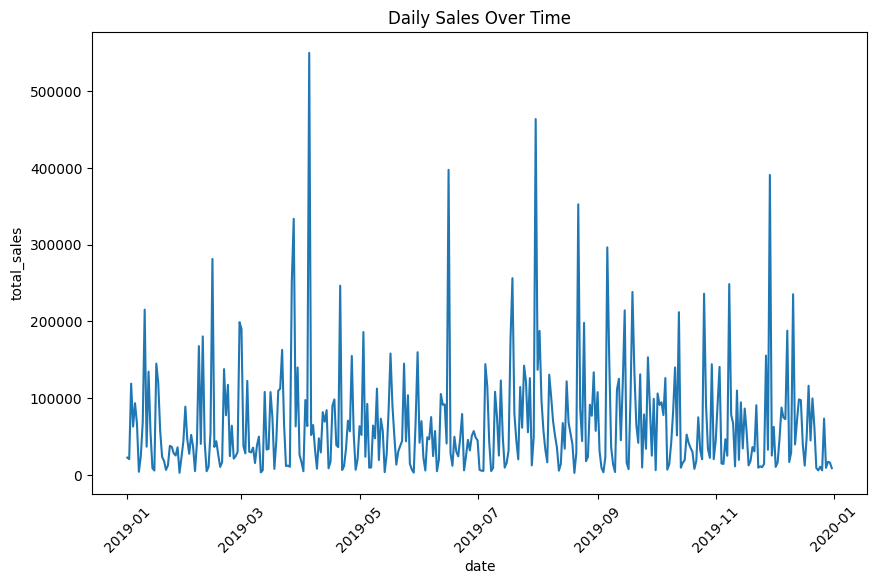

In [42]:
# Plot daily sales
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='total_sales', data=daily_sales)
plt.title('Daily Sales Over Time')
plt.xticks(rotation=45)
plt.show()

In [43]:
# Transactions where total sales are above USD 200,000
historical_sales[historical_sales['total_price'] > 200000]

,user_id,transaction_id,date,product_id,Quantity,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct,age,...,subcategory,actual_price,discounted_price,discount_percentage,average_rating,review_title,review_content,rating_count,total_price,category
11394,13842,24286,2019-03-28,B09WN3SRC7,140,250.01,Clicked,OFF30,0.3,52,...,"Electronics|HomeTheater,TV&Video|Televisions|S...",1678.80,935.88,0.44,4.7,Product installation was excellent but delive...,The delivery people were not careful with the ...,5935,235032.0,Electronics
12393,13113,24863,2019-04-05,B0B9XLX8VR,750,6.50,Used,EXTRA10,0.1,29,...,"Electronics|HomeTheater,TV&Video|Televisions|S...",780.00,455.99,0.42,4.3,Good TV for the price. (But my experience was ...,",Screen quality is good.It's been a month I bo...",3587,341992.5,Electronics
23073,14621,30550,2019-06-16,B0B9XLX8VR,475,6.00,Clicked,EXTRA30,0.3,31,...,"Electronics|HomeTheater,TV&Video|Televisions|S...",780.00,455.99,0.42,4.3,Good TV for the price. (But my experience was ...,",Screen quality is good.It's been a month I bo...",3587,370500.0,Electronics
30268,13081,34193,2019-07-31,B0B9XLX8VR,500,12.99,Clicked,EXTRA10,0.1,18,...,"Electronics|HomeTheater,TV&Video|Televisions|S...",780.00,455.99,0.42,4.3,Good TV for the price. (But my experience was ...,",Screen quality is good.It's been a month I bo...",3587,390000.0,Electronics
34786,13488,36323,2019-08-22,B0B9XLX8VR,300,50.93,Clicked,OFF20,0.2,57,...,"Electronics|HomeTheater,TV&Video|Televisions|S...",780.00,455.99,0.42,4.3,Good TV for the price. (But my experience was ...,",Screen quality is good.It's been a month I bo...",3587,234000.0,Electronics
48974,15144,45142,2019-11-29,B0B2RBP83P,475,504.00,Not Used,OFF20,0.2,25,...,Computers&Accessories|Laptops|TraditionalLaptops,718.68,446.96,0.38,4.0,"Value for money laptop for normal usage,Works ...",If you are looking for a decent laptop and res...,323,341373.0,Computers&Accessories


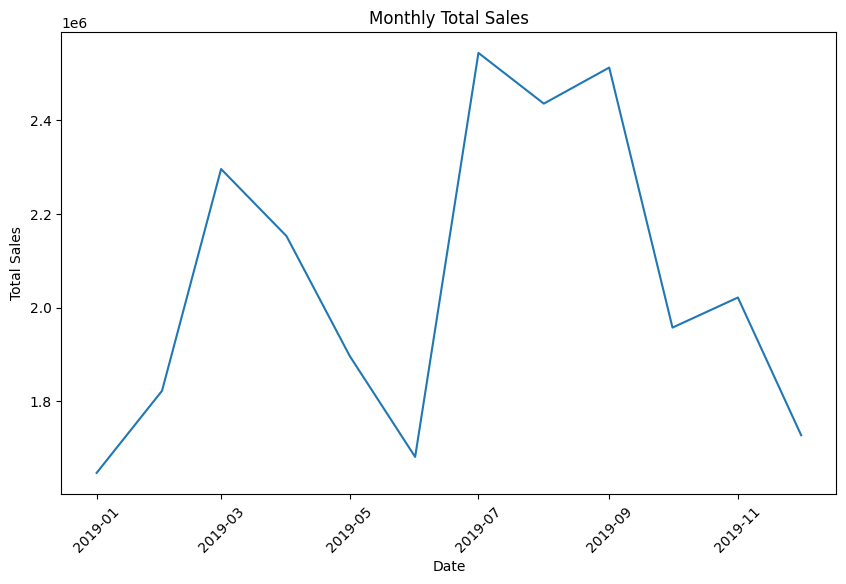

In [44]:
# Plot monthly total sales
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='total_sales', data=monthly_sales)
plt.title('Monthly Total Sales')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

In [45]:
# Aggregate total sales by month and category
monthly_sales_by_category = historical_sales.groupby([historical_sales['date'].dt.to_period('M'), historical_sales['category']]).agg(total_sales=('total_price', 'sum')).reset_index()
monthly_sales_by_category['date'] = monthly_sales_by_category['date'].dt.to_timestamp()
monthly_sales_by_category.head()

,date,category,total_sales
0,2019-01-01,Computers&Accessories,300890.42
1,2019-01-01,Electronics,1216556.78
2,2019-01-01,Home&Kitchen,123569.90
3,2019-01-01,OfficeProducts,5666.50
4,2019-02-01,Computers&Accessories,281698.35


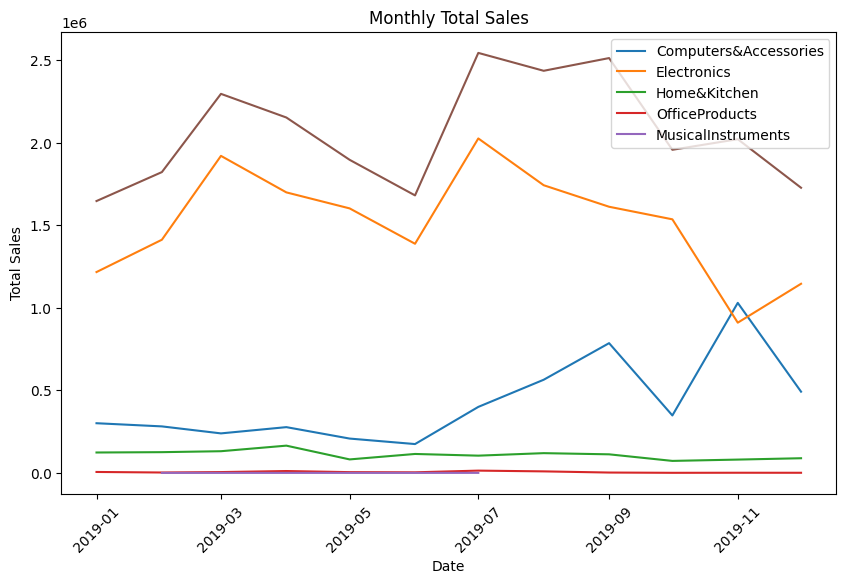

In [46]:
# Plot monthly total sales
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='total_sales', hue='category', data=monthly_sales_by_category)
sns.lineplot(x='date', y='total_sales', data=monthly_sales)
plt.title('Monthly Total Sales')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()
# add legend for total sales!!!

There is a peak in total sales in the July which decreases towards the end of the year. However, it is hard to determine if this is a pattern as we only have one year's worth, of data.  
Excluding the month of November, we see sales peaking in March, April, June, July and August which coincides with the exceptionally large transactions previously.

We also see that the major contributor of sales comes from products under the "Electronics" category and the two lines generally follow the same trend except in November where there is a drastic increase in "Computers&Accessories" products.

In [47]:
# Total sales by category
top_products = historical_sales.groupby('category').agg(total_sales=('total_price', 'sum')).reset_index()

# Sort by total sales
top_products = top_products.sort_values(by='total_sales', ascending=False).head()
top_products

,category,total_sales
1,Electronics,18210011.65
0,Computers&Accessories,5101468.64
2,Home&Kitchen,1320718.82
4,OfficeProducts,59868.63
3,MusicalInstruments,233.15


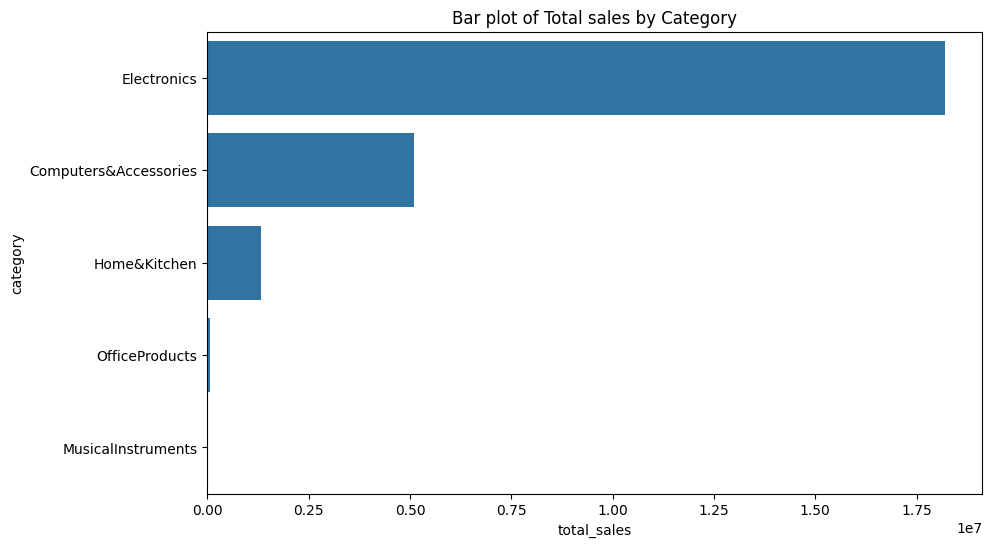

In [48]:
# Bar plot of top sales by Category
plt.figure(figsize=(10,6))
sns.barplot(x='total_sales', y='category', data=top_products)
plt.title('Bar plot of Total sales by Category')
plt.show()


In [49]:
# Total sales by product
top_products = historical_sales.groupby('product_name').agg(total_sales=('total_price', 'sum')).reset_index()

# Sort by total sales
top_products = top_products.sort_values(by='total_sales', ascending=False).head(10)


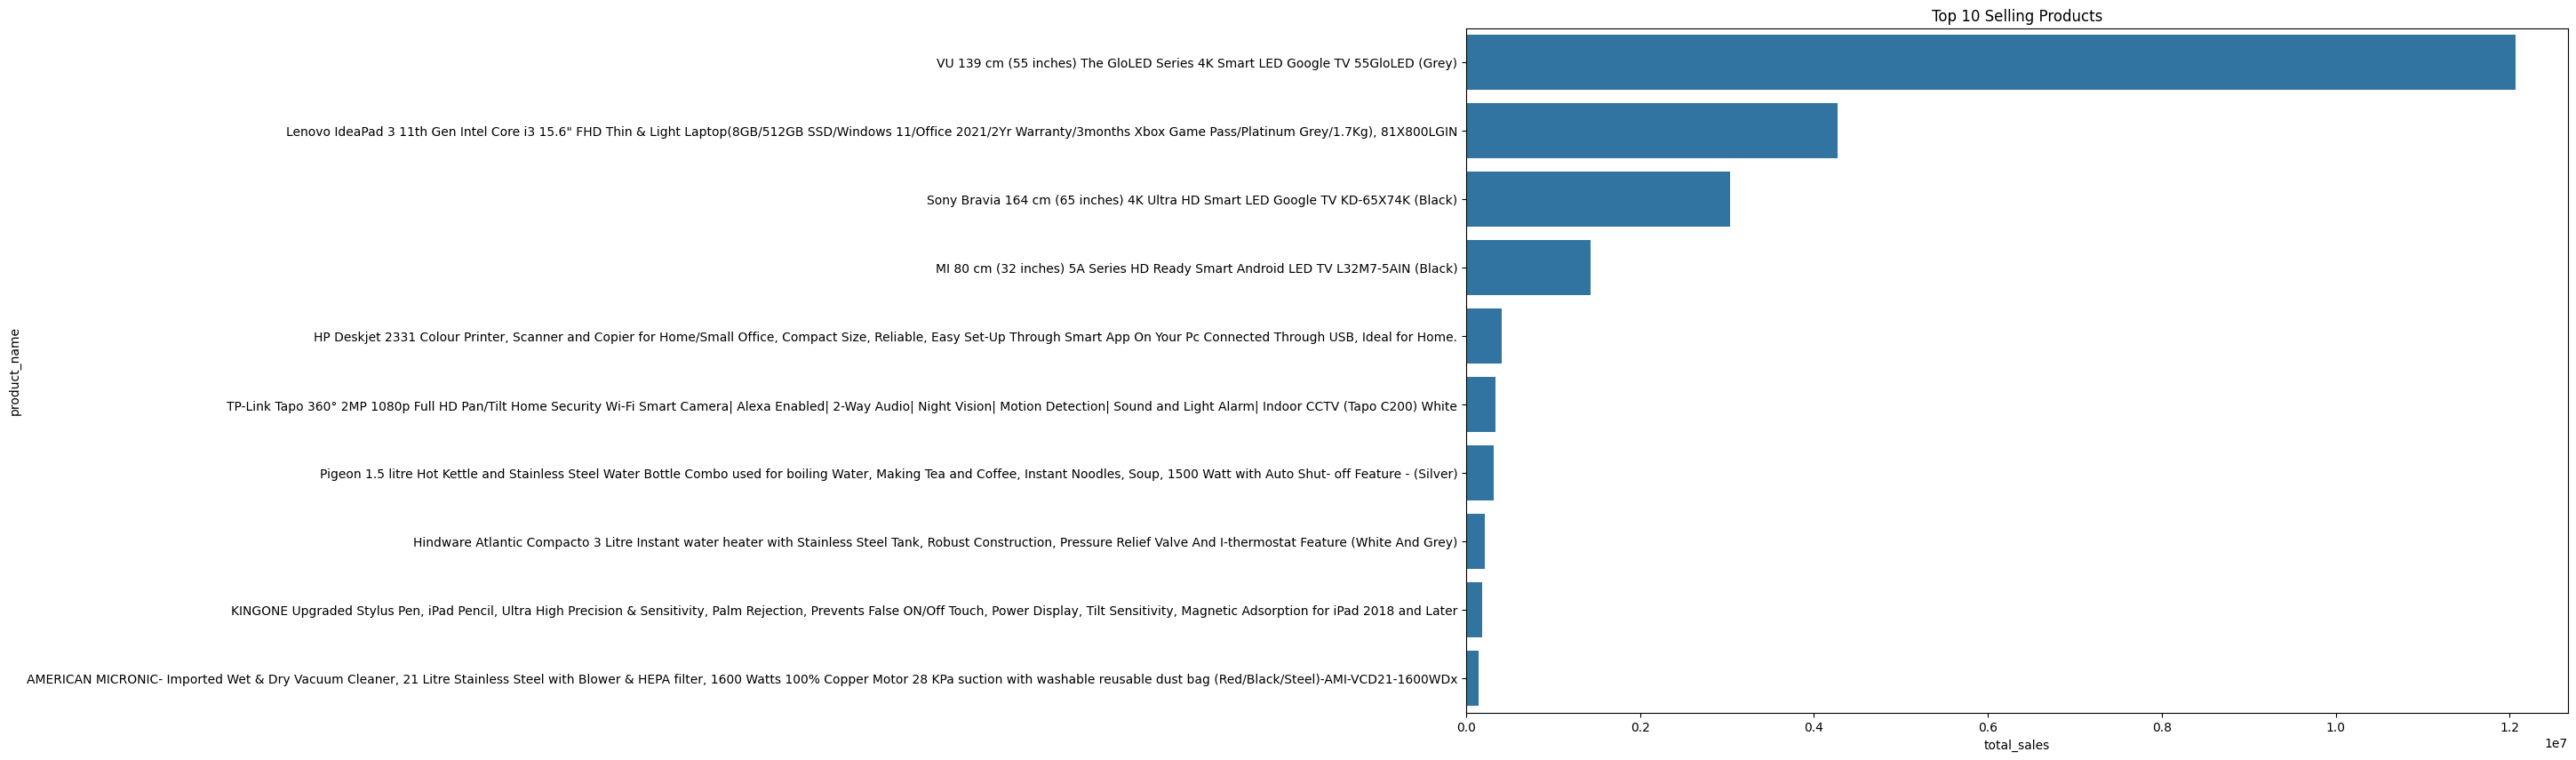

In [50]:
# Bar plot of top 10 products
plt.figure(figsize=(16,10))
sns.barplot(x='total_sales', y='product_name', data=top_products)
plt.title('Top 10 Selling Products')
plt.show()


We see that a large marjority of the total sales is contributed by the 'Electronics' category followed by the 'Computers&Accessories' category and coincides with the top 10 selling products.

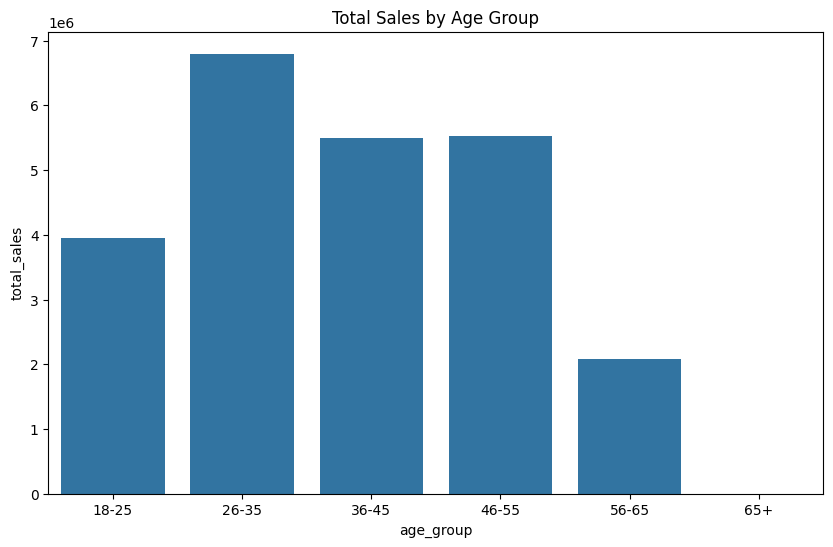

In [51]:
# Creating age bins
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
historical_sales['age_group'] = pd.cut(historical_sales['age'], bins=bins, labels=labels)

# Aggregate sales by age group
age_group_sales = historical_sales.groupby('age_group').agg(total_sales=('total_price', 'sum')).reset_index()

# Bar plot of sales by age group
plt.figure(figsize=(10,6))
sns.barplot(x='age_group', y='total_sales', data=age_group_sales)
plt.title('Total Sales by Age Group')
plt.show()


People aged 26-35 spend the most online.

   gender  total_sales
0  Female  11918929.31
1    Male  12773371.58


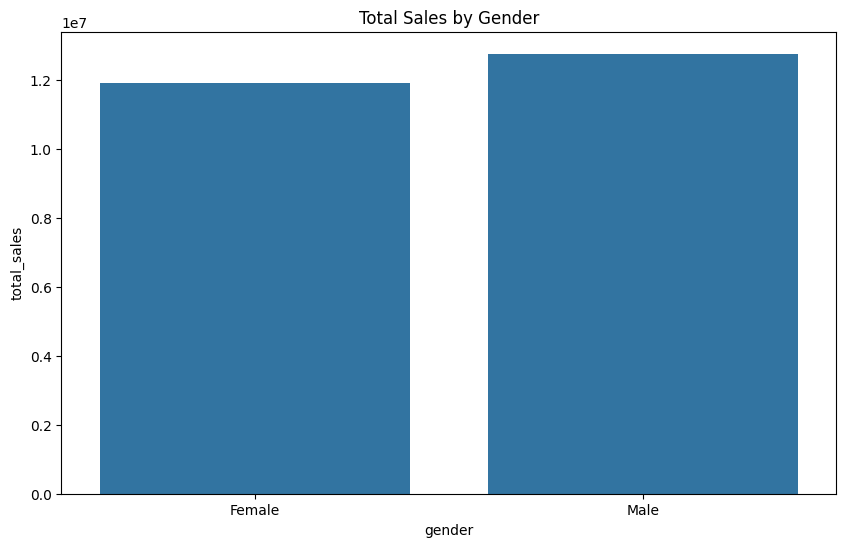

In [52]:
# Total sales by gender
gender_sales = historical_sales.groupby('gender').agg(total_sales=('total_price', 'sum')).reset_index()
print(gender_sales)
# Bar plot of sales by gender
plt.figure(figsize=(10,6))
sns.barplot(x='gender', y='total_sales', data=gender_sales)
plt.title('Total Sales by Gender')
plt.show()


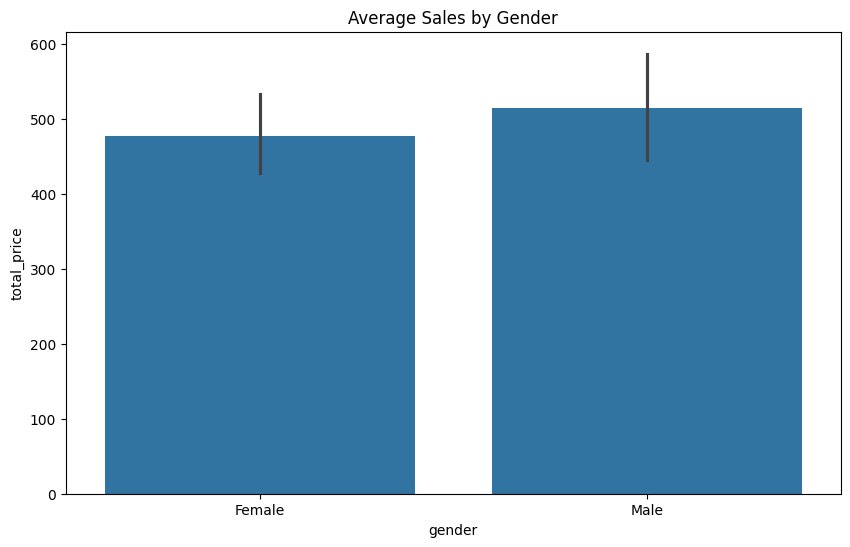

In [53]:
# average sales by gender
plt.figure(figsize=(10,6))
sns.barplot(x='gender', y='total_price', data=historical_sales)
plt.title('Average Sales by Gender')
plt.show()

Males tend to spend slightly more than females on average.

type
repeat      1400
one-time      68
Name: count, dtype: int64


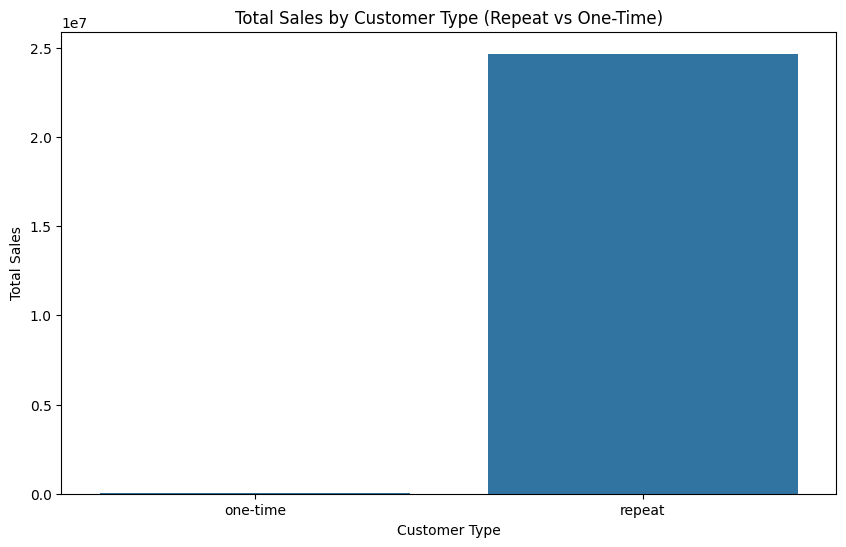

In [54]:
# Count the number of purchases per customer
customer_type = historical_sales.groupby('user_id').agg(total_orders=('transaction_id', 'count')).reset_index()
# Classify customers as 'repeat' or 'one-time'
customer_type['type'] = customer_type['total_orders'].apply(lambda x: 'repeat' if x > 1 else 'one-time')

# Aggregate sales by customer type
customer_type_sales = pd.merge(historical_sales, customer_type[['user_id', 'type']], on='user_id')
customer_type_sales = customer_type_sales.groupby('type').agg(total_sales=('total_price', 'sum')).reset_index()
print(customer_type['type'].value_counts())

# Plot sales by customer type
plt.figure(figsize=(10,6))
sns.barplot(x='type', y='total_sales', data=customer_type_sales)
plt.title('Total Sales by Customer Type (Repeat vs One-Time)')
plt.ylabel('Total Sales')
plt.xlabel("Customer Type")
plt.show()


A large majority of the shoppers are repeat shoppers, indicating that most customers are retained.

In [55]:
# convert necessary columns to float64
historical_sales['actual_price'] = pd.to_numeric(historical_sales['actual_price'], errors='coerce')
historical_sales['discounted_price'] = pd.to_numeric(historical_sales['discounted_price'], errors='coerce')
historical_sales['discount_percentage'] = pd.to_numeric(historical_sales['discount_percentage'], errors='coerce')
historical_sales['total_price'] = pd.to_numeric(historical_sales['total_price'], errors='coerce')
historical_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49714 entries, 0 to 53700
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49714 non-null  int64         
 1   transaction_id       49714 non-null  int64         
 2   date                 49714 non-null  datetime64[ns]
 3   product_id           49714 non-null  object        
 4   Quantity             49714 non-null  int64         
 5   Delivery_Charges     49714 non-null  float64       
 6   Coupon_Status        49714 non-null  object        
 7   Coupon_Code          49714 non-null  object        
 8   Discount_pct         49714 non-null  float64       
 9   age                  49714 non-null  int64         
 10  gender               49714 non-null  object        
 11  product_name         49714 non-null  object        
 12  about_product        49714 non-null  object        
 13  subcategory          49714 non-null 

In [56]:
encoded_sales = historical_sales.drop(columns=['user_id', 'transaction_id', 'date', 'product_id', 
                              'Coupon_Code', 'product_name', 'about_product', 'review_title',
                              'review_content', 'age_group', 'actual_price', 'discounted_price'])
encoded_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49714 entries, 0 to 53700
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Quantity             49714 non-null  int64  
 1   Delivery_Charges     49714 non-null  float64
 2   Coupon_Status        49714 non-null  object 
 3   Discount_pct         49714 non-null  float64
 4   age                  49714 non-null  int64  
 5   gender               49714 non-null  object 
 6   subcategory          49714 non-null  object 
 7   discount_percentage  49714 non-null  float64
 8   average_rating       49714 non-null  float64
 9   rating_count         49714 non-null  int64  
 10  total_price          49714 non-null  float64
 11  category             49714 non-null  object 
dtypes: float64(5), int64(3), object(4)
memory usage: 4.9+ MB


In [57]:
cols = encoded_sales.select_dtypes(include='object').columns
le=LabelEncoder()

for i in cols:
  encoded_sales[i]=le.fit_transform(encoded_sales[i])

encoded_sales.head()

,Quantity,Delivery_Charges,Coupon_Status,Discount_pct,age,gender,subcategory,discount_percentage,average_rating,rating_count,total_price,category
0,1,6.5,2,0.1,33,0,46,0.48,4.1,444,28.79,2
1,1,6.5,2,0.1,33,0,46,0.48,4.1,444,28.79,2
2,1,6.5,2,0.1,33,0,29,0.80,4.3,42641,1.19,1
3,5,6.5,1,0.1,33,0,0,0.63,4.4,28791,47.90,0
4,1,6.5,2,0.1,33,0,31,0.13,3.9,14266,31.19,1


Correlation Matrix 

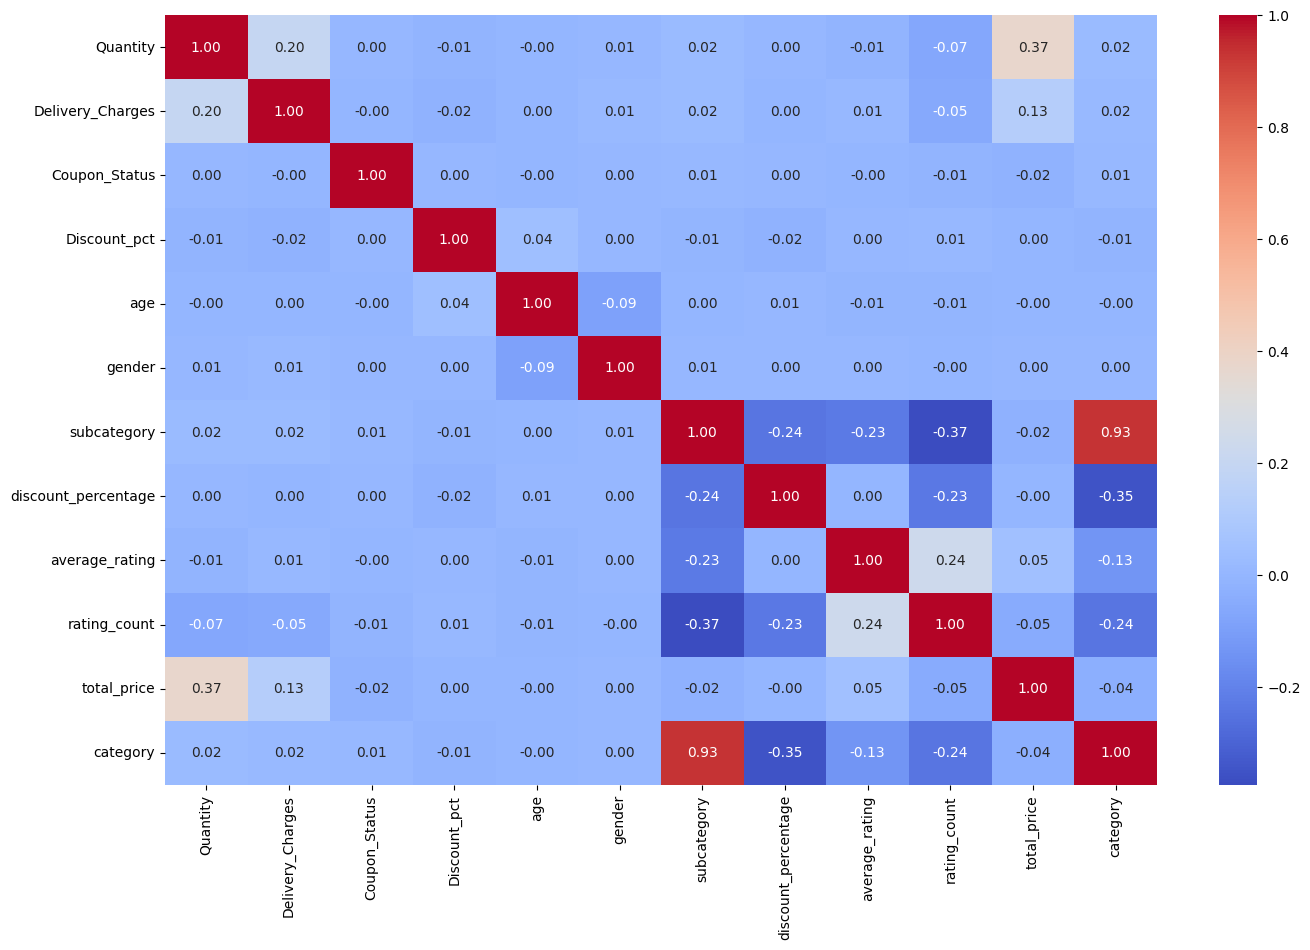

In [58]:
correlation_matrix = encoded_sales.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

None of the features are highly correlated.

## Part 2: Analyse purchasing behaviour

#### RFM (Recency, Frequency, Monetary) Analysis

In [59]:
historical_sales['total_price'] = historical_sales['total_price'].astype(float)

# Set a dummy reference date for recency calculations
reference_date = pd.to_datetime('2024-10-05')

rfm = historical_sales.groupby('user_id').agg({
    'date': lambda x: (reference_date - x.max()).days,  
    'transaction_id': 'count',                         
    'total_price': 'sum'                             
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
user_id,,,
12346,1847,2,1061.91
12347,1799,58,10728.08
12348,1813,20,24780.17
12350,1757,17,11875.48
12356,1847,33,4666.94


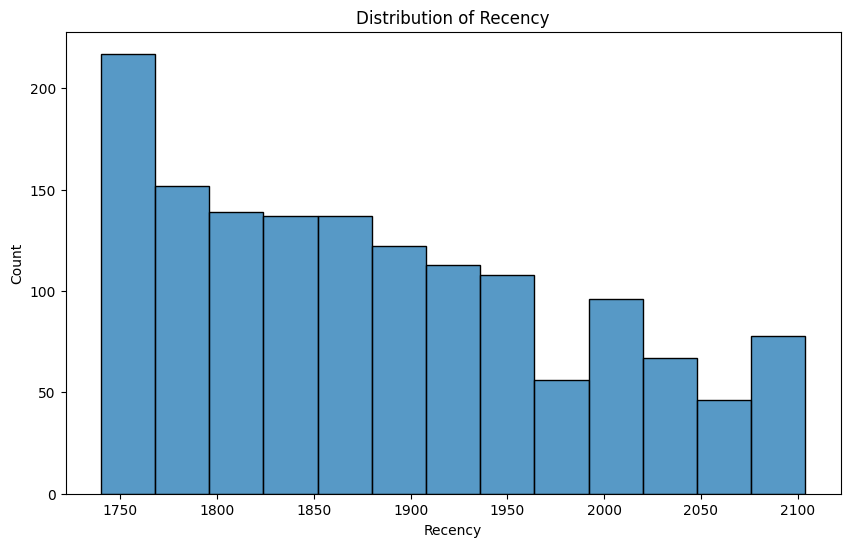

In [60]:
# Distribution of Recency
plt.figure(figsize=(10,6))
sns.histplot(data=rfm, x='Recency')
plt.title("Distribution of Recency")
plt.show()

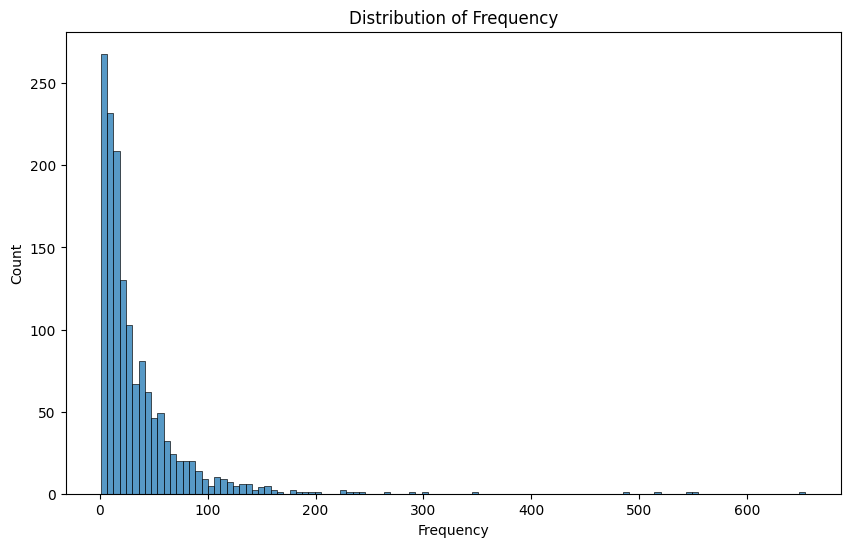

In [61]:
# Distribution of Frequency
plt.figure(figsize=(10,6))
sns.histplot(data=rfm, x='Frequency')
plt.title("Distribution of Frequency")
plt.show()

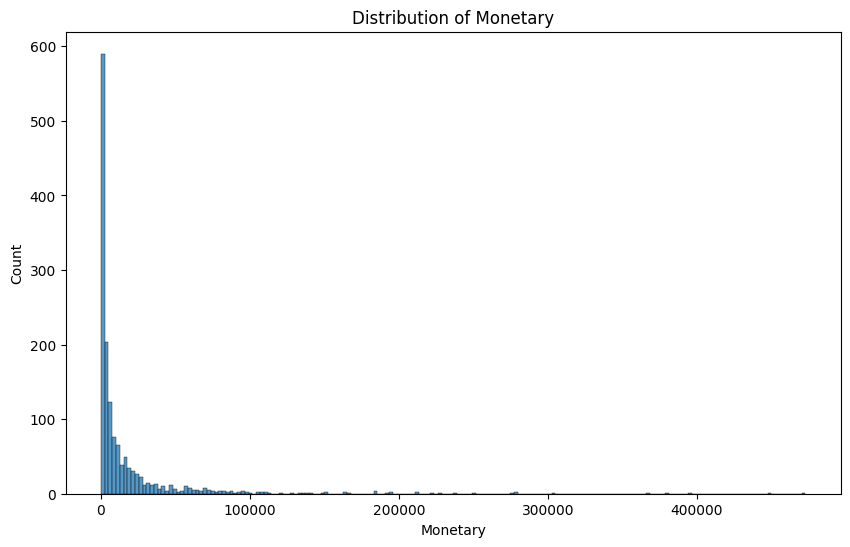

In [62]:
# Distribution of Monetary
plt.figure(figsize=(10,6))
sns.histplot(data=rfm, x='Monetary')
plt.title("Distribution of Monetary")
plt.show()

In [63]:
# Rank each customer for Recency, Frequency, and Monetary
rfm['Recency_rank'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['Frequency_rank'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['Monetary_rank'] = pd.qcut(rfm['Monetary'].astype(float), 5, labels=[1, 2, 3, 4, 5])  # Ensuring Monetary is float

rfm['RFM_Score'] = rfm['Recency_rank'].astype(int) + rfm['Frequency_rank'].astype(int) + rfm['Monetary_rank'].astype(int)

# Customer segmentation based on RFM score
rfm['Segment'] = pd.cut(rfm['RFM_Score'], bins=[2, 5, 8, 11, 15], labels=['Low', 'Medium', 'High', 'Top'])

rfm.head()

,Recency,Frequency,Monetary,Recency_rank,Frequency_rank,Monetary_rank,RFM_Score,Segment
user_id,,,,,,,,
12346,1847,2,1061.91,3,1,2,6,Medium
12347,1799,58,10728.08,4,5,4,13,Top
12348,1813,20,24780.17,4,3,5,12,Top
12350,1757,17,11875.48,5,3,4,12,Top
12356,1847,33,4666.94,3,4,3,10,High


Each customer was assigned a rank based from 1 - 5 for Recency, Frequency and Monetary based on their last purchase, total number of purchases and total amount spent respectively.  
The total of their ranks will result in their RFM score.
The RFM scores were split into Low (2-5), Medium (6-8), High (9-11) and Top (12-15).  
This means customers with higher RFM scores, who are frequent buyers, have high spending, and recently made purchases, will fall into the Top segment, while those with lower RFM scores, reflecting infrequent, low-value purchases or long inactivity, will fall into the Low segment.

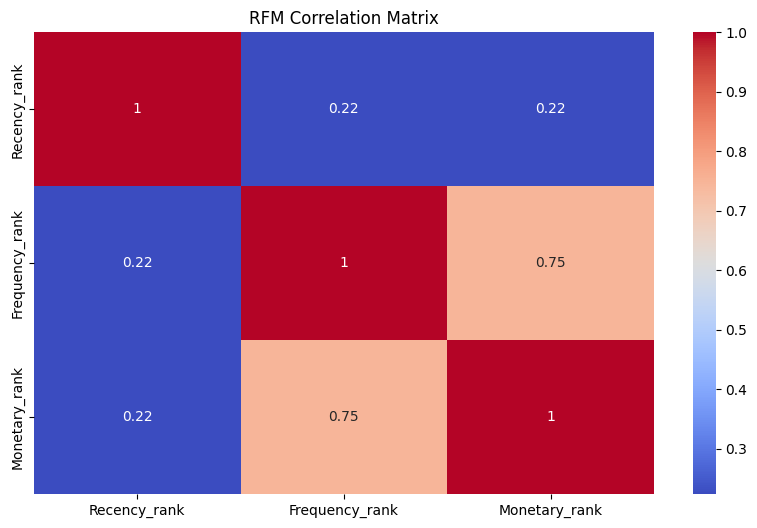

In [64]:
rfm_corr = rfm[['Recency_rank', 'Frequency_rank', 'Monetary_rank']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(rfm_corr, annot=True, cmap='coolwarm')
plt.title('RFM Correlation Matrix')
plt.show()


We see that Frequency and Monetary has a relatively strong positive correlation of 0.75.  
This implies that customers who make purchases more frequently also tend to spend more money (higher monetary value) and could mean that customers with frequent purchases are likely higher-value customers, making them important for retention efforts.

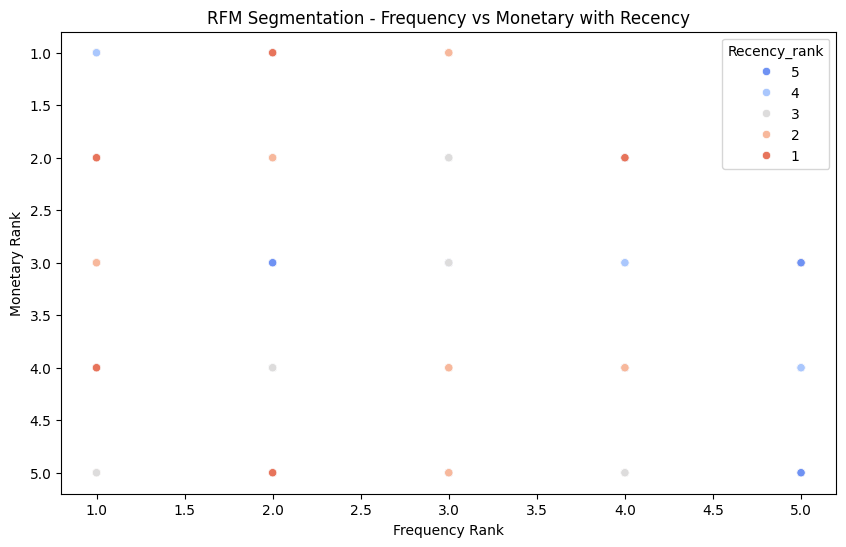

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency_rank', y='Monetary_rank', hue='Recency_rank', data=rfm, palette='coolwarm')
plt.title('RFM Segmentation - Frequency vs Monetary with Recency')
plt.xlabel('Frequency Rank')
plt.ylabel('Monetary Rank')
plt.show()


There is a general trend where customers recency rank increases as their frequency and monetary rank increases as well. This trend reflects that loyal, high-spending customers are also the most recent ones to engage with the company, making them valuable to the business.

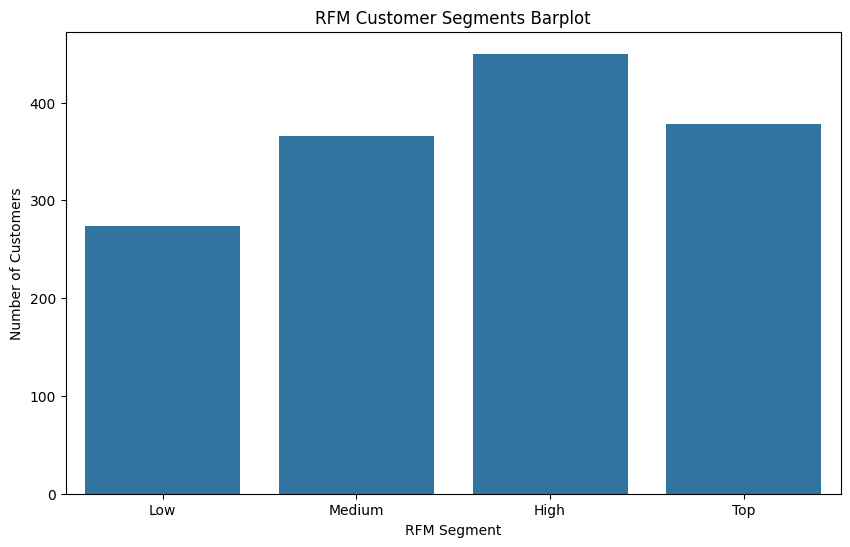

In [66]:
# rfm['RFM_Segment'] = rfm['Recency_rank'].astype(str) + rfm['Frequency_rank'].astype(str) + rfm['Monetary_rank'].astype(str)

rfm_segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=rfm_segment_counts.index, y=rfm_segment_counts.values)
plt.title('RFM Customer Segments Barplot')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.show()


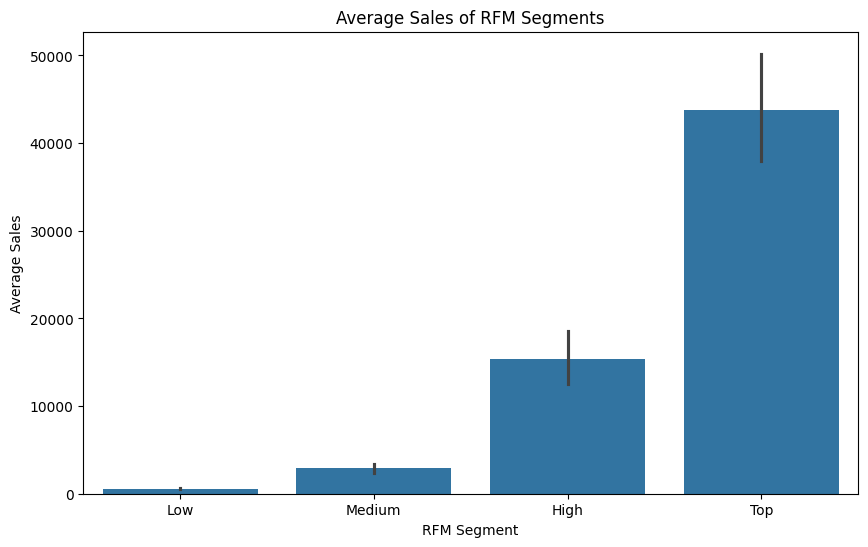

In [67]:
plt.figure(figsize=(10, 6))
sns.barplot(x=rfm['Segment'], y=rfm['Monetary'])
plt.title('Average Sales of RFM Segments')
plt.xlabel('RFM Segment')
plt.ylabel('Average Sales')
plt.show()

We see that most of the customers fall under the High and Top segments.  Considering that these customers likely drive a significant portion of revenue as seen by their average sales, it would be wise to focus on maintaining engagement and offering exclusive deals or loyalty programs to sustain their high purchase rates.


#### Customer Lifetime Value (CLTV)

CLTV is a metric which provides insight into how much revenue a customer might bring in over time and allows us to predict how much revenue a customer will contribute over the average estimated length of time that they are a customer.  

The formula we will use is CLTV = ((Average Order x Purchase Frequency) / Churn Rate) x Profit margin 

In [68]:
# Aggregate data at the customer level
customer_data = historical_sales.groupby('user_id').agg({
    'transaction_id': 'count',           # Number of orders (Frequency)
    'total_price': 'sum',                  # Total revenue (Monetary)
    'date': ['min', 'max'],                # Recency
    'product_id': 'nunique',               # Number of unique products purchased
}).reset_index()

customer_data.columns = ['user_id', 'total_orders', 'total_revenue', 'first_purchase', 'last_purchase', 'unique_products']
customer_data

,user_id,total_orders,total_revenue,first_purchase,last_purchase,unique_products
0,12346,2,1061.91,2019-09-15,2019-09-15,2
1,12347,58,10728.08,2019-03-24,2019-11-02,33
2,12348,20,24780.17,2019-06-22,2019-10-19,16
3,12350,17,11875.48,2019-12-14,2019-12-14,7
4,12356,33,4666.94,2019-09-15,2019-09-15,25
...,...,...,...,...,...,...
1463,18259,5,1948.73,2019-04-05,2019-04-05,4
1464,18260,37,4013.33,2019-06-22,2019-10-05,25
1465,18269,8,822.75,2019-04-05,2019-06-20,7
1466,18277,1,110.16,2019-10-23,2019-10-23,1


In [69]:
# Calculate recency as the difference between the last purchase and a reference date (latest purchase date)
reference_date = historical_sales['date'].max()
customer_data['recency'] = (reference_date - customer_data['last_purchase']).dt.days
customer_data.head()

,user_id,total_orders,total_revenue,first_purchase,last_purchase,unique_products,recency
0,12346,2,1061.91,2019-09-15,2019-09-15,2,107
1,12347,58,10728.08,2019-03-24,2019-11-02,33,59
2,12348,20,24780.17,2019-06-22,2019-10-19,16,73
3,12350,17,11875.48,2019-12-14,2019-12-14,7,17
4,12356,33,4666.94,2019-09-15,2019-09-15,25,107


In [70]:
# Calculate average order value (AOV)
# The AOV is the ratio of the total revenue and the total number of orders. It represents the amount of revenue 
# a customer spends on an order.
customer_data['AOV'] = customer_data['total_revenue'] / customer_data['total_orders']

In [71]:
# Calculate Purchase frequency (orders per day)
# Purchase frequency is the ratio of the total number of orders and the total number of customers. It represents the
# average number of orders placed by each customer.
'''
customer_data['purchase_days'] = (customer_data['last_purchase'] - customer_data['first_purchase']).dt.days + 1
customer_data['frequency'] = customer_data['total_orders'] / customer_data['purchase_days']
'''

purchase_frequency = sum(customer_data['total_orders'])/customer_data.shape[0]
print(f"Purchase Frequency: {purchase_frequency}")

Purchase Frequency: 33.86512261580381


In [72]:
# Calculate Repeat Rate
# Repeat rate is the ratio of the number of customers with more than one order to the number of unique customers

repeat = len(customer_type[customer_type.type == 'repeat'])
one_time = len(customer_type[customer_type.type == 'one-time'])
repeat_rate = repeat/(repeat + one_time)
print(f"Repeat Rate: {repeat_rate}")

Repeat Rate: 0.9536784741144414


In [73]:
# Calculate Churn Rate
# Churn rate is the percentage of customers who have not ordered again
# churn rate = 1 - repeat rate

churn_rate = 1 - repeat_rate
print(f"Churn Rate: {churn_rate}")

Churn Rate: 0.0463215258855586


In [74]:
# Calculate Customer Lifetime
# Customer lifetime is the period of time that the customer has been ordering
# customer lifetime = 1 / churn rate

customer_lifetime = 1/churn_rate
print(f"Customer Lifetime: {customer_lifetime}")

Customer Lifetime: 21.588235294117638


In [75]:
# Calculate Profit Margin
# Take Amazon's sellers have a profit margin of 20% based on research 

customer_data['profit_margin'] = customer_data['total_revenue']*0.2
customer_data.head()

,user_id,total_orders,total_revenue,first_purchase,last_purchase,unique_products,recency,AOV,profit_margin
0,12346,2,1061.91,2019-09-15,2019-09-15,2,107,530.955000,212.382
1,12347,58,10728.08,2019-03-24,2019-11-02,33,59,184.966897,2145.616
2,12348,20,24780.17,2019-06-22,2019-10-19,16,73,1239.008500,4956.034
3,12350,17,11875.48,2019-12-14,2019-12-14,7,17,698.557647,2375.096
4,12356,33,4666.94,2019-09-15,2019-09-15,25,107,141.422424,933.388


In [76]:
# Calculate CLTV
customer_data['CLTV'] = ((customer_data['AOV']*purchase_frequency)/churn_rate) * customer_data['profit_margin']
customer_data.head()

,user_id,total_orders,total_revenue,first_purchase,last_purchase,unique_products,recency,AOV,profit_margin,CLTV
0,12346,2,1061.91,2019-09-15,2019-09-15,2,107,530.955000,212.382,8.244137e+07
1,12347,58,10728.08,2019-03-24,2019-11-02,33,59,184.966897,2145.616,2.901455e+08
2,12348,20,24780.17,2019-06-22,2019-10-19,16,73,1239.008500,4956.034,4.489297e+09
3,12350,17,11875.48,2019-12-14,2019-12-14,7,17,698.557647,2375.096,1.212979e+09
4,12356,33,4666.94,2019-09-15,2019-09-15,25,107,141.422424,933.388,9.650510e+07


In [77]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          1468 non-null   int64         
 1   total_orders     1468 non-null   int64         
 2   total_revenue    1468 non-null   float64       
 3   first_purchase   1468 non-null   datetime64[ns]
 4   last_purchase    1468 non-null   datetime64[ns]
 5   unique_products  1468 non-null   int64         
 6   recency          1468 non-null   int64         
 7   AOV              1468 non-null   float64       
 8   profit_margin    1468 non-null   float64       
 9   CLTV             1468 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int64(4)
memory usage: 114.8 KB


CLTV Quantile Analysis

In [78]:
# Create quantile-based segments for CLTV
customer_data['cltv_segment'] = pd.qcut(customer_data['CLTV'], q=4, labels=['Low', 'Medium', 'High', 'Top'])

# Analyze the distribution of CLTV segments
print(customer_data['cltv_segment'].value_counts())

# Example: Average total orders in each CLTV segment
cltv_analysis = customer_data.groupby('cltv_segment').agg({
    'total_orders': 'mean',
    'AOV': 'mean',
    'CLTV': 'mean',
    'profit_margin': 'mean'
}).reset_index()

print(cltv_analysis)

cltv_segment
Low       367
Medium    367
High      367
Top       367
Name: count, dtype: int64
  cltv_segment  total_orders          AOV          CLTV  profit_margin
0          Low      8.583106    50.302325  3.469077e+06      80.844441
1       Medium     22.043597   155.865517  5.223134e+07     518.035760
2         High     40.863760   302.046977  3.507112e+08    1811.394234
3          Top     63.970027  1564.848699  2.224934e+10   11046.020327


CLTV K-means Clustering Analysis

   cltv_cluster  total_orders           AOV     recency          CLTV  \
0             0     29.878345    516.222986   75.821168  3.664105e+09   
1             1     20.955986    368.172968  252.950704  2.036482e+09   
2             2     20.000000  18890.610484  109.200000  6.994139e+11   
3             3    180.150685    450.735863   72.246575  8.890057e+09   

   profit_margin  
0    2956.484146  
1    1751.302363  
2   56187.044400  
3   16884.318438  


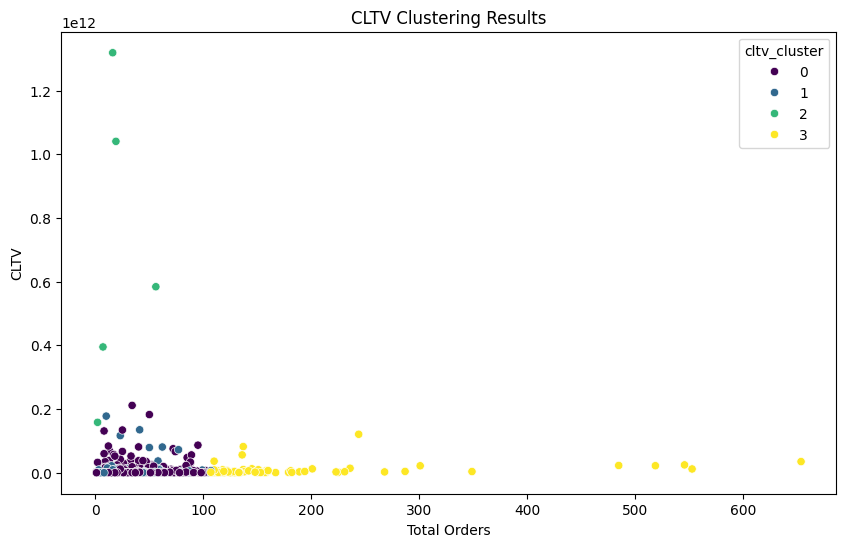

In [79]:
X = customer_data[['total_orders', 'AOV', 'recency', 'CLTV']]

# Standardize the features for better performance in KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_data['cltv_cluster'] = kmeans.fit_predict(X_scaled)

# Analyze the clusters
cluster_analysis = customer_data.groupby('cltv_cluster').agg({
    'total_orders': 'mean',
    'AOV': 'mean',
    'recency': 'mean',
    'CLTV': 'mean',
    'profit_margin': 'mean'
}).reset_index()

print(cluster_analysis)

# Visualize clusters (CLTV vs. total orders)
plt.figure(figsize=(10,6))
sns.scatterplot(x=customer_data['total_orders'], y=customer_data['CLTV'], hue=customer_data['cltv_cluster'], palette='viridis')
plt.title('CLTV Clustering Results')
plt.xlabel('Total Orders')
plt.ylabel('CLTV')
plt.show()

There are no distinct segments in the data points.

#### CLTV Prediction Model

In [80]:
# drop CLTV outlier 
customer_data = customer_data.drop([customer_data[customer_data['CLTV']==max(customer_data['CLTV'])].index[0]])

In [81]:
# Calculate customer lifetime in days
customer_data['customer_lifetime_days'] = (customer_data['last_purchase'] - customer_data['first_purchase']).dt.days + 1

# Calculate purchase frequency
customer_data['purchase_frequency'] = customer_data['total_orders'] / customer_data['customer_lifetime_days']

# Calculate time between purchases
customer_data['avg_time_between_purchases'] = customer_data['recency'] / customer_data['total_orders']

# Final feature set for model
features = customer_data[['total_orders', 'total_revenue', 'unique_products', 'recency', 
                          'AOV', 'profit_margin', 'customer_lifetime_days', 'purchase_frequency', 
                          'avg_time_between_purchases']]
target = customer_data['CLTV']
features.head()

,total_orders,total_revenue,unique_products,recency,AOV,profit_margin,customer_lifetime_days,purchase_frequency,avg_time_between_purchases
0,2,1061.91,2,107,530.955000,212.382,1,2.000000,53.500000
1,58,10728.08,33,59,184.966897,2145.616,224,0.258929,1.017241
2,20,24780.17,16,73,1239.008500,4956.034,120,0.166667,3.650000
3,17,11875.48,7,17,698.557647,2375.096,1,17.000000,1.000000
4,33,4666.94,25,107,141.422424,933.388,1,33.000000,3.242424


In [82]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [83]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Linear Regression Model

In [84]:
# Linear Regression Model
model = LinearRegression()

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_train_scaled)

In [85]:
# Linear Regression Evaluation
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Mean Squared Error: 5.961919883878861e+20
R-squared: 0.6577417005297257
Intercept: 5452129988.814828
Coefficients: [-1.50411340e+10  1.21485733e+10  2.01343115e+09 -5.16553903e+08
  1.87561408e+10  1.21485733e+10 -2.22279469e+08  1.20063142e+08
 -1.38549549e+08]


The linear regression model has an R-squared value of about 0.658 which is a reasonable fit but not good enough .

Random Forest Model

In [86]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

In [87]:
# Random Forest Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 3.761551851563061e+19
R-squared: 0.8301726045418022


The R-squared value of 0.824 is much higher than previously seen in the linear regression model indicating an immprovement.

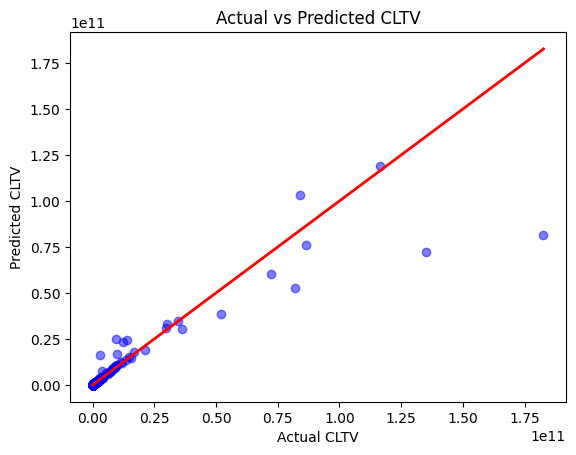

In [88]:
# Scatter plot of Actual vs Predicted CLTV for RF
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2) 
plt.xlabel('Actual CLTV')
plt.ylabel('Predicted CLTV')
plt.title('Actual vs Predicted CLTV')
plt.show()


Generally, we see that the predicted blue points follow the values of the red line, with a few cases of over and under prediction especially as the CLTV increases.